# First Name: Ali
# Family Name: MOKRANI


# Generative Modeling with Variational Autoencoders

Generative modeling aims at learning the underlying distribution of complex data in order to generate new, realistic samples. Among probabilistic generative models, **Variational Autoencoders (VAEs)** offer a principled approach that combines neural networks with variational inference. VAEs enable both data reconstruction and sampling from a continuous latent space, making them suitable for tasks such as interpolation and representation learning.

However, classical VAEs rely on a simple isotropic Gaussian prior in latent space. In practice, the aggregated posterior often deviates from this assumption, which can limit the quality and diversity of generated samples. Recent approaches address this limitation by learning more expressive latent priors.

### Objectives
*   To train and analyze a Variational Autoencoder on the **FashionMNIST** dataset.
*   To study the influence of key hyperparameters such as **latent dimension**, **model complexity**, and the **$\beta$ coefficient**.
*   To prepare a latent space suitable for learning a richer prior using **Flow Matching**.

---

## 1. Dataset
We use the **FashionMNIST** dataset, which consists of 70,000 grayscale images of size $28 \times 28$, depicting clothing items from 10 categories (e.g., T-shirts, trousers, sneakers). The dataset is split into 50,000 training images, 10,000 for validation and 10,000 test images.

All images are normalized to the range $[0,1]$. FashionMNIST is more challenging than MNIST due to higher intra-class variability, making it a suitable benchmark for evaluating generative models.

---

## 2. Variational Autoencoder (VAE)

### 2.1 Model Architecture
A Variational Autoencoder is composed of two neural networks:
*   **An encoder** $q_\phi(z \mid x)$ that maps an input image $x$ to a latent distribution.
*   **A decoder** $p_\theta(x \mid z)$ that reconstructs the input from a latent sample $z$.

The encoder outputs the parameters of a Gaussian distribution:
$$\mu(x), \quad \log \sigma^2(x)$$

from which a latent vector is sampled using the **reparameterization trick**:
$$z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

This formulation enables backpropagation through the stochastic sampling step.

### 2.2 Loss Function
The VAE is trained by minimizing the Evidence Lower Bound (ELBO), defined as:
$$\mathcal{L} = \mathcal{L}_{\text{rec}} + \beta \, \mathcal{L}_{\text{KL}}$$

The reconstruction term $\mathcal{L}_{\text{rec}}$ measures how accurately the decoder reconstructs the input, while the KL divergence term enforces proximity between the approximate posterior $q(z \mid x)$ and the standard normal prior $\mathcal{N}(0, I)$.

The hyperparameter $\beta$ controls the trade-off between reconstruction quality and latent space regularization.

---

## 3. Hyperparameters

### 3.1 Latent Space Dimension
The latent dimension determines the capacity of the compressed representation. Low-dimensional latent spaces encourage smoothness and disentanglement but may limit reconstruction quality. Higher-dimensional latent spaces allow richer representations at the cost of weaker regularization.

Several values were tested for each model architecture to determine the optimal one.

### 3.2 Model Complexity
We experimented with architectures of increasing complexity:
*   **Small model:** hidden layers of size (32, 64)
*   **Medium model:** hidden layers of size (128, 256)
*   **Large model:** hidden layers of size (128, 256, 512)

Larger models generally yield improved reconstruction quality and more expressive latent representations, at the cost of increased computational requirements.

### 3.3 Influence of the $\beta$ Parameter
The choice of $\beta$ has a strong impact on the learned representation.
*   For **large values** (e.g., $\beta = 40$), the latent distribution closely matches a Gaussian prior, but reconstruction quality degrades significantly.
*   For **very small values** (e.g., $\beta = 0.01$), the model behaves similarly to a standard autoencoder, resulting in excellent reconstructions but poor sampling and interpolation properties.

### 3.4 Beta Annealing
To address this trade-off, we employ a **$\beta$-annealing strategy** using a linear scheduler. The value of $\beta$ is gradually increased from 0 to a target value over a fixed number of warm-up epochs. This approach allows the model to first focus on reconstruction before enforcing latent regularization.



## Data Loading: Fahsion MNIST

In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

Exécution sur cuda:0


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.7MB/s]


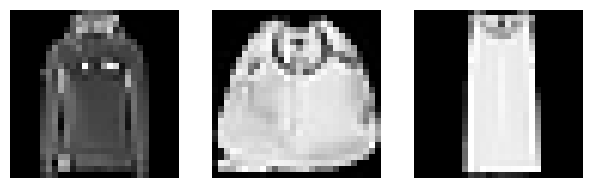

In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt

# Load full training set
full_train = FashionMNIST(root='./data', train=True, download=True, transform=ToTensor())

# Split → 50k train / 10k validation (common split)
train_size = 50000
val_size   = 10000
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=ToTensor())

# Visualize
n_images = 3
fig = plt.figure(figsize=(10, 5))

for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images + 1, i + 1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images - 1:
        break

plt.show()

## VAE architechture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 latent_dim: int = 16,
                 hidden_dims: list = None,
                 input_size: int = 28):
        super(VariationalAutoencoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_size = input_size  # Store input size to force output match

        # Default configuration if none provided
        if hidden_dims is None:
            hidden_dims = [32, 64, 128]

        # ===========================
        # Build Encoder
        # ===========================
        modules = []

        # Build a layer for each dimension in hidden_dims
        current_channels = in_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(current_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            current_channels = h_dim

        self.encoder = nn.Sequential(*modules)

        # Calculate the size of the features after the last conv layer automatically
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, input_size, input_size)
            self.encoder_output_shape = self.encoder(dummy_input).shape
            self.flatten_dim = self.encoder_output_shape[1] * self.encoder_output_shape[2] * self.encoder_output_shape[3]

        # Latent Space Projections
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # ===========================
        # Build Decoder
        # ===========================
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)

        modules = []
        hidden_dims.reverse() # Reverse [128, 64, 32]

        # We need to go from [128 -> 64], [64 -> 32], [32 -> input_channels]
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    # Using kernel=3, stride=2, padding=1, output_padding=1 DOUBLES the spatial dimension exactly
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1],
                                       kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )

        self.decoder_layers = nn.Sequential(*modules)

        # Final Layer to map back to original channels
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1],
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    def decode(self, z):
        result = self.decoder_input(z)
        # Reshape back to (Batch, Channel, Height, Width) based on encoder output
        result = result.view(-1, self.encoder_output_shape[1], self.encoder_output_shape[2], self.encoder_output_shape[3])
        result = self.decoder_layers(result)
        result = self.final_layer(result)

        # === FIX: Ensure output size matches input size exactly ===
        if result.shape[2] != self.input_size or result.shape[3] != self.input_size:
            result = F.interpolate(result, size=(self.input_size, self.input_size), mode='bilinear', align_corners=False)

        return result

    def latent_sample(self, mu, logvar):
        if self.training:
            # logvar is log(std^2)
            # std = exp(0.5 * logvar)
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.latent_sample(mu, logvar)
        hat_x = self.decode(z)
        return hat_x, mu, logvar

# Loss function
def vae_loss(hat_x, x, mu, logvar):
    # Sum over all pixels
    reconstruction_loss = F.binary_cross_entropy(hat_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss, kl_divergence

In [5]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# Datasets
full_train = FashionMNIST(root='./data', train=True, download=True, transform=ToTensor())
train_ds, val_ds = random_split(full_train, [50000, 10000])
test_ds = FashionMNIST(root='./data', train=False, download=True, transform=ToTensor())

def train_vae(net, train_dataset, val_dataset, epochs=50, learning_rate=1e-3, batch_size=128, device='cuda', beta_final=4.0, warmup_epochs=20):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    net = net.to(device)

    train_recon, train_kl, train_total = [], [], []
    val_recon,   val_kl,   val_total   = [], [], []

    t = trange(1, epochs + 1, desc="Training")
    for epoch in t:
        # Linear KL annealing
        beta = beta_final * min(1.0, epoch / warmup_epochs)

        net.train()
        tr_recon_sum = tr_kl_sum = tr_total_sum = 0.
        for images, _ in train_loader:
            images = images.to(device)
            recon, mu, logvar = net(images)
            recon_loss, kl_loss = vae_loss(recon, images, mu, logvar)
            loss = recon_loss + beta * kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_recon_sum += recon_loss.item()
            tr_kl_sum    += kl_loss.item()
            tr_total_sum += loss.item()

        n = len(train_loader.dataset)
        train_recon.append(tr_recon_sum / n)
        train_kl.append(tr_kl_sum / n)
        train_total.append(tr_total_sum / n)

        net.eval()
        vl_recon_sum = vl_kl_sum = vl_total_sum = 0.
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                recon, mu, logvar = net(images)
                recon_loss, kl_loss = vae_loss(recon, images, mu, logvar)
                loss = recon_loss + beta * kl_loss
                vl_recon_sum += recon_loss.item()
                vl_kl_sum    += kl_loss.item()
                vl_total_sum += loss.item()

        n_val = len(val_loader.dataset)
        val_recon.append(vl_recon_sum / n_val)
        val_kl.append(vl_kl_sum / n_val)
        val_total.append(vl_total_sum / n_val)

        t.set_description(f"Ep {epoch} | β {beta:.2f} | tr {train_total[-1]:.1f} re {train_recon[-1]:.1f} kl {train_kl[-1]:.1f}")

    net = net.cpu()

    # Plots
    epochs_range = range(1, epochs+1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.plot(epochs_range, train_recon, label='train')
    ax1.plot(epochs_range, val_recon,   label='val')
    ax1.set_title('Reconstruction Loss')
    ax1.legend(); ax1.grid(True)

    ax2.plot(epochs_range, train_kl, label='train')
    ax2.plot(epochs_range, val_kl,   label='val')
    ax2.set_title('KL Divergence')
    ax2.legend(); ax2.grid(True)

    ax3.plot(epochs_range, train_total, label='train')
    ax3.plot(epochs_range, val_total,   label='val')
    ax3.set_title(f'Total Loss (β → {beta_final})')
    ax3.legend(); ax3.grid(True)

    plt.tight_layout()
    plt.savefig('loss_curves_annealing.jpg')
    plt.show()

    return net

## Model Training

### Final VAE Configuration

Following our hyperparameter search, we converged on a **Convolutional Variational Autoencoder (CVAE)** architecture. This model utilizes deep spatial feature extraction rather than simple fully connected layers, allowing it to better capture the geometric structures of the FashionMNIST clothing items.

#### Model Architecture
The model consists of a symmetrical encoder-decoder structure with the following specifications:

*   **Encoder:** Three convolutional blocks with increasing filter counts (128, 256, 512). Each block employs a $3 \times 3$ kernel, a stride of 2 for downsampling, and **Batch Normalization** to stabilize training. **LeakyReLU** activations are used to prevent "dying ReLU" neurons.
*   **Latent Space:** The feature map is flattened to a vector of size 8,192 before being projected into a **24-dimensional** latent space ($z \in \mathbb{R}^{24}$). This dimension was chosen to provide sufficient capacity for the 10 fashion categories while maintaining a compact representation.
*   **Decoder:** A mirror of the encoder using **Transposed Convolutions** to upsample the latent vector back to the original $28 \times 28$ spatial resolution.
*   **Output Layer:** A final $1 \times 1$ convolution followed by a **Sigmoid activation** is used to ensure the reconstructed pixel intensities are bounded within the $[0, 1]$ range.

| Feature | Specification |
| :--- | :--- |
| **Encoder Layers** | Conv2d(Stride 2) $\to$ BatchNorm $\to$ LeakyReLU |
| **Latent Dimension** | 24 |
| **Decoder Layers** | ConvTranspose2d $\to$ BatchNorm $\to$ LeakyReLU |
| **Activation (Output)** | Sigmoid |

#### Training Protocol
The model was trained using the Adam optimizer with a specific emphasis on $\beta$-annealing to ensure a well-organized latent space without sacrificing reconstruction quality.

```python
# Training Hyperparameters Summary
Training_Config = {
    "Epochs": 120,
    "Learning Rate": 0.003,
    "Batch Size": 128,
    "Latent Dim": 24,
    "Beta Final": 1.0,
    "Warmup Epochs": 40
}
```

By setting $\beta_{\text{final}} = 1.0$, we target a standard VAE framework where the latent space is regularized toward a Normal distribution. The **40-epoch warmup** period is critical: it allows the encoder to first learn meaningful reconstructions ($\beta \approx 0$) before the KL-divergence constraint gradually forces the latent clusters into a continuous manifold suitable for generative sampling.

Training:   0%|          | 0/120 [00:00<?, ?it/s]

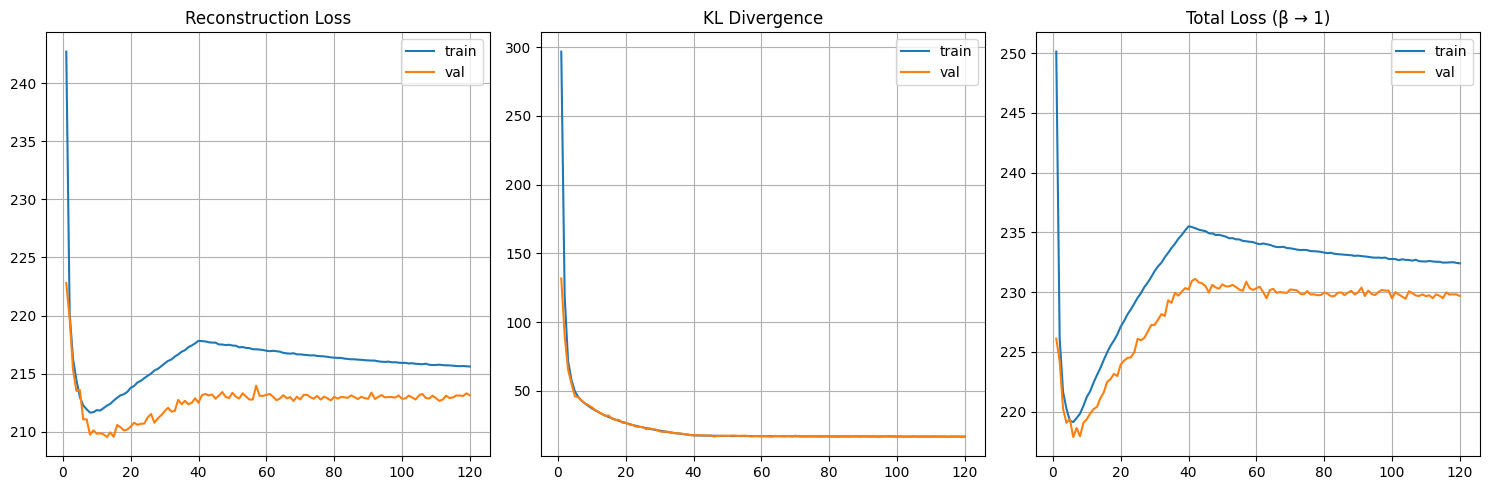

In [10]:
# latent_dim = 35
vae_standard = VariationalAutoencoder(
    in_channels=1,
    latent_dim=24,
    hidden_dims=[ 128, 265, 512],  # Deeper network
    input_size=28
).to(device)
# vae = VariationalAutoencoder(latent_dim).to(device)
net = train_vae(vae_standard, train_dataset,val_dataset, epochs=120, learning_rate=3e-3, batch_size=128, device=device, beta_final = 1, warmup_epochs = 40)

In [28]:
# After training
torch.save(vae_standard.state_dict(), "vae_standard_latent24.pt")

# or with more info
torch.save({
    'epoch': 120,
    'model_state_dict': vae_standard.state_dict(),  # if you want optimizer too
}, "vae_checkpoint.pth")

## Reconstruction, Sampling, interpolating witht the trained model

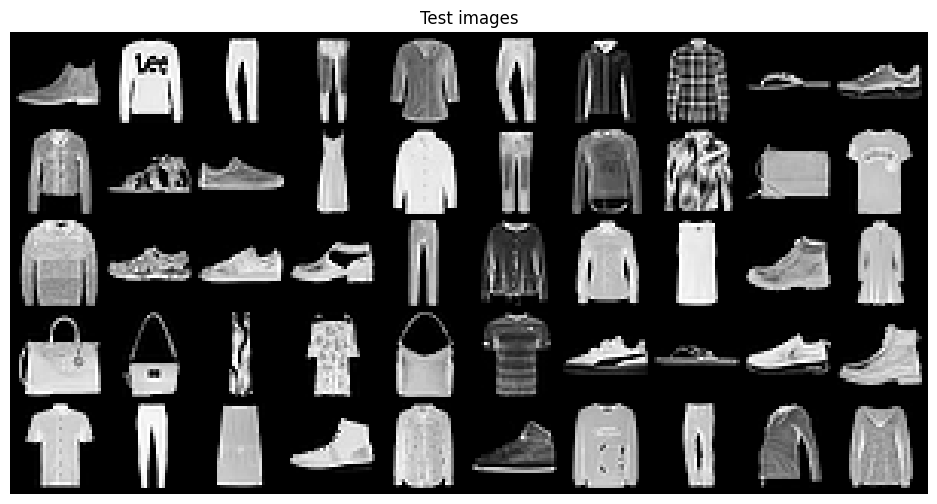

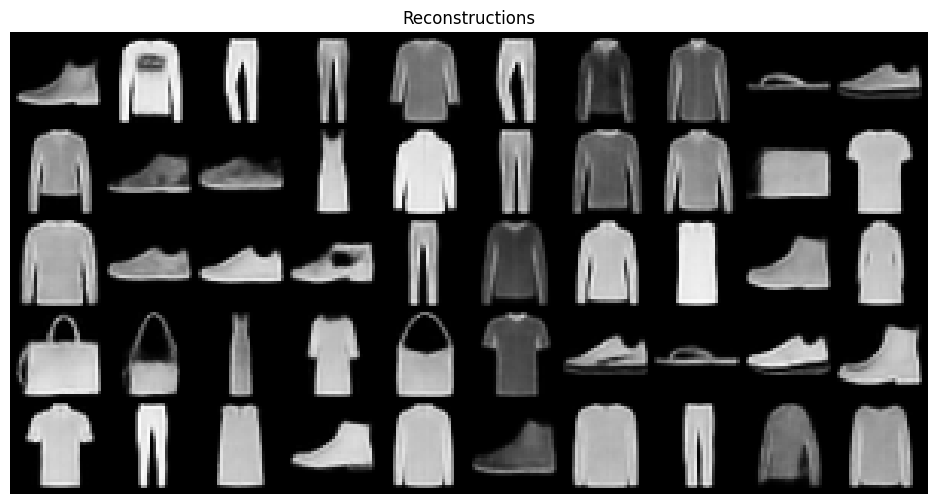

In [12]:
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

net = net.to(device)          # ← add this right after training
net = net.eval()
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

def visualize_reconstructions(net, images, device=device):
    with torch.no_grad():
        images = images.to(device)
        reconstructions, _, _ = net(images)           # take only recon (first output)
        grid = make_grid(reconstructions[:50], nrow=10).cpu()
        return grid

# Get batch
images, _ = next(iter(test_dataloader))

# Originals
plt.figure(figsize=(12, 6))
plt.title("Test images")
show_grid(make_grid(images[:50], nrow=10))

# Reconstructions
plt.figure(figsize=(12, 6))
plt.title("Reconstructions")
show_grid(visualize_reconstructions(net, images))

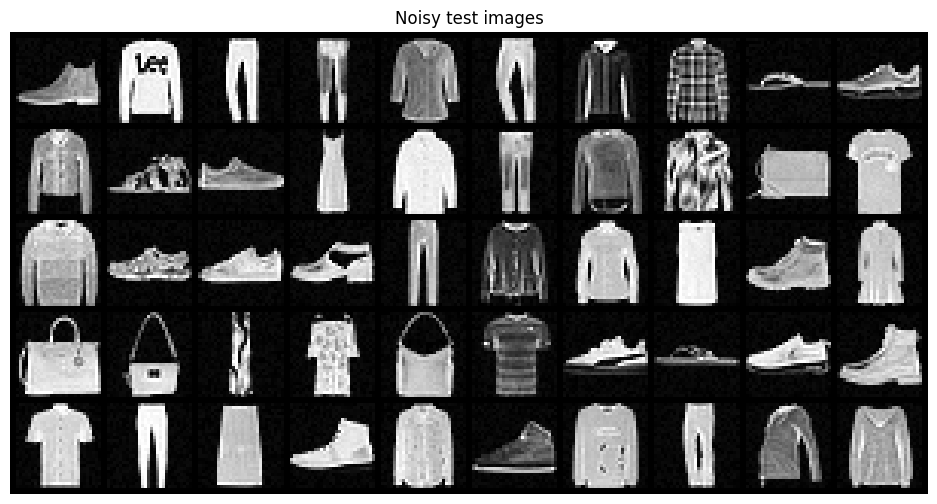

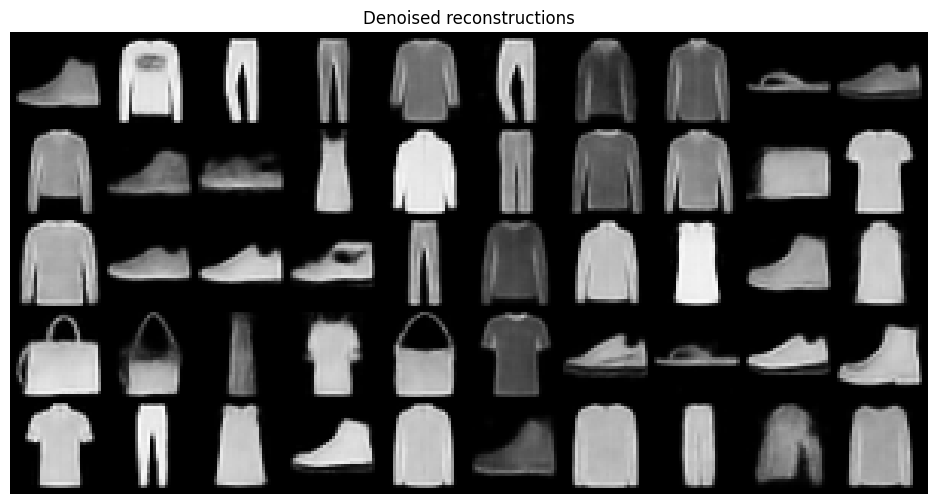

In [15]:
noise_factor = 0.05
noise = noise_factor * torch.rand_like(images)
noisy_images = torch.clamp(images + noise, 0., 1.)

# Noisy images
plt.figure(figsize=(12, 6))
plt.title("Noisy test images")
show_grid(make_grid(noisy_images[:50], nrow=10))

# Reconstructions from noisy input
plt.figure(figsize=(12, 6))
plt.title("Denoised reconstructions")
show_grid(visualize_reconstructions(net, noisy_images))

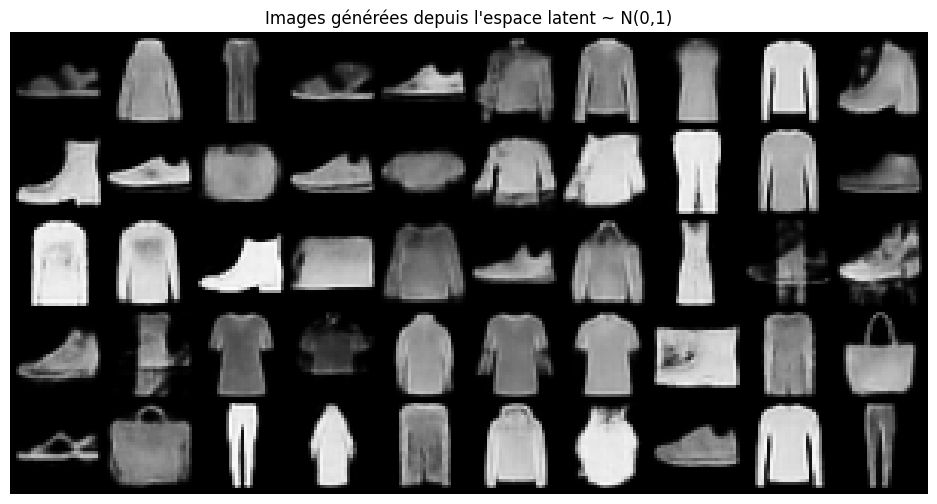

In [17]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

# Nombre d'images à générer
n_samples = 50

# Échantillonnage ~ N(0, I)
z = torch.randn(n_samples, 24)

# Décodage direct
with torch.no_grad():
    generated = net.decode(z.to(device))

# Grille
grid = make_grid(generated, nrow=10).cpu()

# Affichage
plt.figure(figsize=(12, 6))
plt.title("Images générées depuis l'espace latent ~ N(0,1)")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
plt.axis('off')
plt.show()

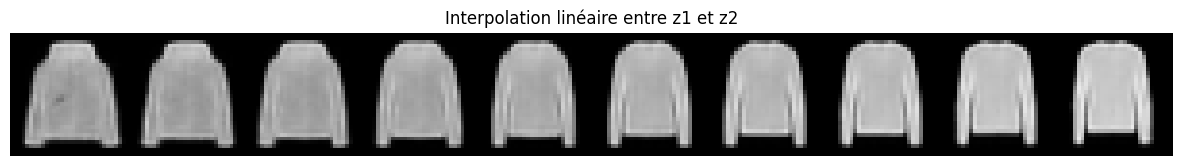

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
latent_dim = 24

# Deux points aléatoires dans l'espace latent
z1 = torch.randn(1, latent_dim, device=device)
z2 = torch.randn(1, latent_dim, device=device)

# 10 étapes d'interpolation (linspace inclut les extrémités)
n_steps = 10
alphas = torch.linspace(0, 1, n_steps, device=device).view(-1, 1, 1)

# Interpolation linéaire
z_interp = (1 - alphas) * z1 + alphas * z2

with torch.no_grad():
    generated = net.decode(z_interp)

grid = make_grid(generated, nrow=n_steps).cpu()

plt.figure(figsize=(15, 3))
plt.title("Interpolation linéaire entre z1 et z2")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
plt.axis('off')
plt.show()

## Visualising the latent space

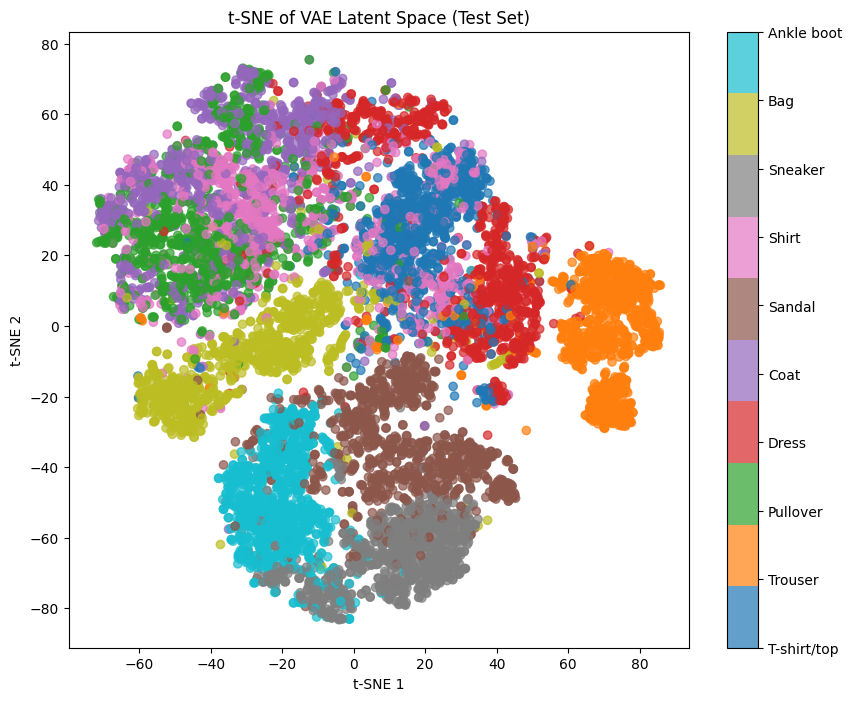

In [26]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Prep
net = net.to(device)
net.eval()
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

latents = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        mu, _ = net.encode(images)
        latents.append(mu.cpu().numpy())
        labels_list.append(labels.numpy())

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels_list, axis=0)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded = tsne.fit_transform(latents)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), format=plt.FuncFormatter(lambda i, *args: classes[int(i)]))
plt.title('t-SNE of VAE Latent Space (Test Set)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## 4. Results and Observations

### 4.1 Reconstruction Quality and Blurriness
The model achieves a low reconstruction loss on the test set. Comparing original test images to their reconstructions, we observe that the global structure and essential features (e.g., sleeves of a shirt, soles of a sneaker) are accurately preserved. As is typical with VAEs, the reconstructed images exhibit a slight **blurriness**. This is an expected trade-off resulting from the use of a Mean Squared Error (MSE) loss, which tends to average out high-frequency details, and the stochastic nature of the latent sampling.

### 4.2 Robustness and Feature Learning
To test the robustness of the learned representations, we conducted a **denoising experiment**. By injecting random Gaussian noise into the test images before encoding them, we found that the model was able to reconstruct clean, noise-free images. This demonstrates that the VAE has not simply memorized the input pixels but has instead learned **robust, high-level features**. It effectively "projects" noisy inputs back onto the learned data manifold, filtering out irrelevant perturbations.

### 4.3 Generative Capabilities and Interpolation
*   **Latent Sampling:** Randomly sampling from the latent prior $z \sim \mathcal{N}(0, I)$ produces realistic images that closely resemble the training distribution. While a few samples show minor structural ambiguities, the vast majority are clearly recognizable as specific clothing items.
*   **Latent Interpolation:** By performing linear interpolation between two random samples in the latent space, we observe **smooth semantic transitions**.

### 4.4 Latent Space Visualization (t-SNE)
A 2D projection of the latent space using **t-SNE** reveals a compact global distribution where the 10 FashionMNIST categories are grouped into identifiable regions. However, there is a visible overlap between several classes.

This overlap is a direct consequence of the **trade-off between reconstruction accuracy and KL regularization**. While the reconstruction term pushes the encoder to separate classes to minimize error, the KL divergence term (weighted by $\beta$) acts as a regularizing force that pulls the entire distribution toward a standard normal prior. This tension prevents the latent space from collapsing into isolated, discrete clusters, instead creating a continuous manifold where the boundaries between similar categories are blurred.

---

## Conclusion of Part I

In this first part, we demonstrated that the performance of a VAE strongly depends on architectural choices and training hyperparameters. By transitioning to a deep convolutional architecture and employing a 24-dimensional latent space with $\beta$-annealing, we achieved high-fidelity reconstructions and a structured latent manifold.

Our results show that the model is capable of robust feature extraction and smooth generative interpolation. However, while the latent space is well-organized, the simple Gaussian prior used during training remains a bottleneck for generating the highest quality samples. This provides the necessary foundation for the second part of this work: replacing the static Gaussian prior with a learned, more flexible prior using **Flow Matching** to capture the true complexity of the aggregated posterior.

# Part II: Latent Flow Matching

## 1. Introduction: Beyond the Gaussian Prior

As observed in the first part of this work, the latent space of a VAE trained with a standard isotropic Gaussian prior $\mathcal{N}(0, I)$ often presents a mismatch between the **prior** (the distribution we sample from) and the **aggregated posterior** (the distribution of actual encoded data). This results in:
*   **Overlap**: Semantic blurring between classes.
*   **Low-density regions**: Areas in the Gaussian prior that do not correspond to realistic images, leading to lower-quality samples.

To address this, we introduce **Flow Matching (FM)**. Instead of forcing the latent space to fit a simple Gaussian distribution, we keep the trained VAE frozen and learn a **time-dependent vector field** that transforms a simple distribution (noise) into the complex, structured distribution of the VAE's latent codes.

---

## 2. Architecture and Methodology

The Flow Matching framework consists of three main components:

### 2.1 The Optimal Transport (OT) Flow
We implement an **Optimal Transport Flow Matching** strategy. We define a probability path that connects a noise distribution $x_0 \sim \mathcal{N}(0, I)$ to our latent data $x_1$ (the VAE encodings).
*   **Linear Interpolation**: The path is defined as $\psi_t(x) = (1 - (1 - \sigma_{min})t)x_0 + t x_1$.
*   **Vector Field**: The goal is to train a neural network $v_t$ to predict the velocity (direction) required to move from noise to data at any time $t \in [0, 1]$.

### 2.2 The Velocity Network (`Net`)
The neural network $v_t$ must be aware of both the current position in the latent space and the current time step.
*   **Time Encoding**: We use a `time_encoder` based on sinusoidal (Fourier) frequencies. This allows the network to learn high-frequency temporal dynamics.
*   **Multi-Layer Perceptron (MLP)**: A deep architecture processes the concatenated latent vector and time embedding to output the predicted velocity.

### 2.3 Conditional Vector Field (`CondVF`)
This is a wrapper that facilitates the inference process. Once the network is trained, we generate new samples by solving an **Ordinary Differential Equation (ODE)**. We start with pure noise at $t=0$ and "flow" it towards the data distribution at $t=1$ using an ODE solver (`odeint`).

---

## 3. Training Procedure

The training process is divided into two distinct phases:

### Phase 1: Latent Extraction
We freeze the weights of the previously trained **Variational Autoencoder**. We pass the entire FashionMNIST dataset through the encoder to extract the mean vectors ($\mu$). These 24-dimensional vectors serve as the "ground truth" data points ($x_1$) for our Flow Matching model. By using $\mu$ rather than stochastic samples, we provide a stable target for the vector field to learn.

### Phase 2: Flow Training
We train the velocity network by minimizing the Flow Matching loss:
1.  **Sample** a latent data point $x_1$ from our extracted dataset and a noise point $x_0$ from a standard Gaussian.
2.  **Sample** a random time $t \sim \text{Unif}([0, 1])$.
3.  **Compute** the target velocity: the straight path from $x_0$ to $x_1$.
4.  **Optimize**: Update the network parameters to minimize the Mean Squared Error (MSE) between the predicted velocity and the target velocity.


### 2.4 Architecture Optimization and Final Selection

Several network architectures were evaluated. We observed that shallower networks struggled to capture the complex velocity fields required to navigate the 24-dimensional latent manifold. We found that **deeper architectures** with higher hidden capacities gave better results for accurately modeling the complex boundaries and high-density regions of the FashionMNIST latent distribution.

The chosen architecture for the velocity network $v_t$ is a deep Multi-Layer Perceptron (MLP) designed as follows:
*   **Temporal Encoding:** We utilize a Fourier feature expansion with **14 frequencies**. This transforms the scalar time $t$ into a high-dimensional embedding, allowing the network to distinguish between early-stage (noise-dominated) and late-stage (structure-refining) flow dynamics.
*   **Hidden Layers:** The network consists of five dense layers with progressively increasing widths: **[128, 256, 512, 512, 1024]**. This expanding capacity allows the model to project latent features into a high-dimensional space where the optimal transport paths are more easily separable.
*   **Activations:** Each layer is followed by a **LeakyReLU** activation to maintain gradient flow throughout the deep structure.

### 3. Training Hyperparameters

The model was trained by minimizing the Mean Squared Error (MSE) between the predicted and target velocities over 300 epochs. This extended training duration was necessary to ensure the vector field converged on a smooth, "straight-path" solution characteristic of Optimal Transport.

| Hyperparameter | Value |
| :--- | :--- |
| **Latent Dimension** | 24 |
| **FM Epochs** | 300 |
| **Learning Rate** | $1 \times 10^{-3}$ |
| **Batch Size** | 256 |
| **Optimizer** | Adam |
| **Time Frequencies** | 14 |
| **ODE Solver** | `odeint` (Zuko/DOPRI5) |


In [27]:
!pip install zuko
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.8 MB/s eta 0:00:00


## Model Architechture

In [31]:
class OTFlowMatching:

  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min
    self.eps = 1e-5

  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x_0)
    x_0 = torch.randn_like(x_1)
    v_psi = v_t(t[:,0], self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)


class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies:int) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)

    for l in self.layers:
      x = l(x)
    return self.top(x)

class CondVF(nn.Module):
  def __init__(self, net: nn.Module, n_steps: int = 100) -> None:
    super().__init__()
    self.net = net

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)

  def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
      t = t * torch.ones(len(x), device=x.device)
      return self(t, x)

  def decode_t0_t1(self, x_0, t0, t1):
    return odeint(self.wrapper, x_0, t0, t1, self.parameters())


  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())

## Data preparation

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List
from zuko.utils import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LATENT_DIM = 24     # Dimension of VAE latent space
FM_EPOCHS = 300     # Number of epochs for Flow Matching
LR = 1e-3

print(f"Running on device: {device}")

vae_standard = VariationalAutoencoder(
    in_channels=1,
    latent_dim=24,
    hidden_dims=[128, 265, 512],
    input_size=28
).to(device)

vae_standard.load_state_dict(torch.load("vae_standard_latent24.pt"))
vae_standard.eval()
vae = vae_standard

def extract_latents(model, dataset, device):
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    latents = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Extracting Latents", ncols=80):
            x = x.to(device)
            mu, _ = model.encode(x) # Use Mean (mu) as ground truth
            latents.append(mu.cpu())
    return torch.cat(latents, dim=0)

# Load Data
full_train = FashionMNIST(root='./data', train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(full_train, [50000, 10000])

print("\n--- Extracting Training Latents ---")
z_train = extract_latents(vae, train_set, device)
print("\n--- Extracting Validation Latents ---")
z_val = extract_latents(vae, val_set, device)

# Create Latent DataLoaders
train_loader_z = DataLoader(TensorDataset(z_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader_z = DataLoader(TensorDataset(z_val), batch_size=BATCH_SIZE, shuffle=False)

Running on device: cuda

--- Extracting Training Latents ---


Extracting Latents: 100%|███████████████████████| 98/98 [00:12<00:00,  7.81it/s]



--- Extracting Validation Latents ---


Extracting Latents: 100%|███████████████████████| 20/20 [00:01<00:00, 13.49it/s]


## Model Training

In [68]:


# Initialize FM Model
fm_net = Net(in_dim=LATENT_DIM, out_dim=LATENT_DIM, h_dims=[128, 256, 512,512, 1024], n_frequencies=14).to(device)
v_t = CondVF(fm_net).to(device)
ot_fm = OTFlowMatching()
optimizer = torch.optim.Adam(v_t.parameters(), lr=LR)

train_losses = []
val_losses = []

print(f"\n--- Starting FM Training ({FM_EPOCHS} epochs) ---")

for epoch in range(FM_EPOCHS):
    # --- Training ---
    v_t.train()
    batch_losses = []
    for (z_batch,) in train_loader_z:
        z_batch = z_batch.to(device)

        loss = ot_fm.loss(v_t, z_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    avg_train_loss = sum(batch_losses) / len(batch_losses)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    v_t.eval()
    val_batch_losses = []
    with torch.no_grad():
        for (z_batch_val,) in val_loader_z:
            z_batch_val = z_batch_val.to(device)
            # Compute loss but don't optimize
            loss_val = ot_fm.loss(v_t, z_batch_val)
            val_batch_losses.append(loss_val.item())

    avg_val_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1:02d}/{FM_EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")



--- Starting FM Training (300 epochs) ---
Epoch 02/300 | Train Loss: 1.22971 | Val Loss: 1.19559
Epoch 04/300 | Train Loss: 1.11323 | Val Loss: 1.10447
Epoch 06/300 | Train Loss: 1.08171 | Val Loss: 1.08564
Epoch 08/300 | Train Loss: 1.06985 | Val Loss: 1.07019
Epoch 10/300 | Train Loss: 1.05346 | Val Loss: 1.04921
Epoch 12/300 | Train Loss: 1.04777 | Val Loss: 1.04937
Epoch 14/300 | Train Loss: 1.03544 | Val Loss: 1.03448
Epoch 16/300 | Train Loss: 1.02135 | Val Loss: 1.02681
Epoch 18/300 | Train Loss: 1.01611 | Val Loss: 1.02076
Epoch 20/300 | Train Loss: 1.01035 | Val Loss: 1.00896
Epoch 22/300 | Train Loss: 0.99379 | Val Loss: 1.00540
Epoch 24/300 | Train Loss: 0.98536 | Val Loss: 0.99748
Epoch 26/300 | Train Loss: 0.97544 | Val Loss: 0.97549
Epoch 28/300 | Train Loss: 0.97243 | Val Loss: 0.96919
Epoch 30/300 | Train Loss: 0.96837 | Val Loss: 0.96884
Epoch 32/300 | Train Loss: 0.96341 | Val Loss: 0.96587
Epoch 34/300 | Train Loss: 0.96268 | Val Loss: 0.96442
Epoch 36/300 | Train L

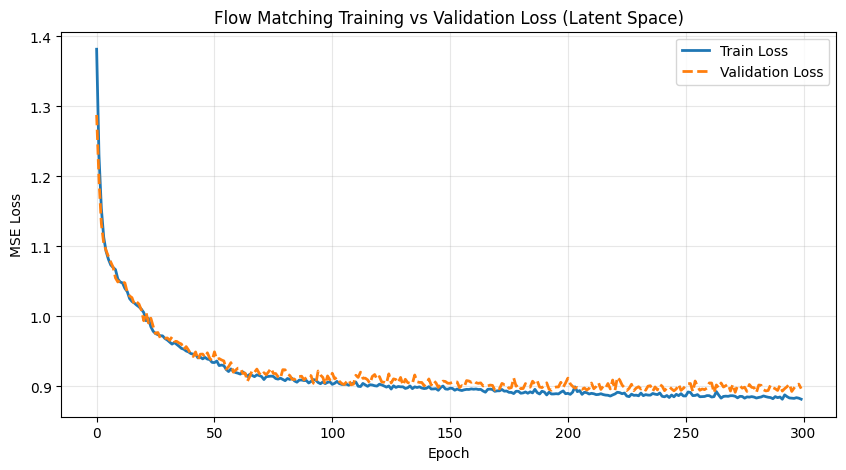

In [69]:
# ==========================================
# 6. PLOTTING & GENERATION
# ==========================================

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2, linestyle='--')
plt.title("Flow Matching Training vs Validation Loss (Latent Space)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Generate Samples
def generate_samples(n=16):
    vae.eval()
    v_t.eval()
    with torch.no_grad():
        # 1. Sample Noise (x_0)
        z_0 = torch.randn(n, LATENT_DIM).to(device)

        # 2. Flow Matching ODE (Noise -> Latent)
        z_gen = v_t.decode(z_0)

        # 3. VAE Decode (Latent -> Image)
        imgs = vae.decode(z_gen)
        return imgs.cpu()


## Sampling using the FM model

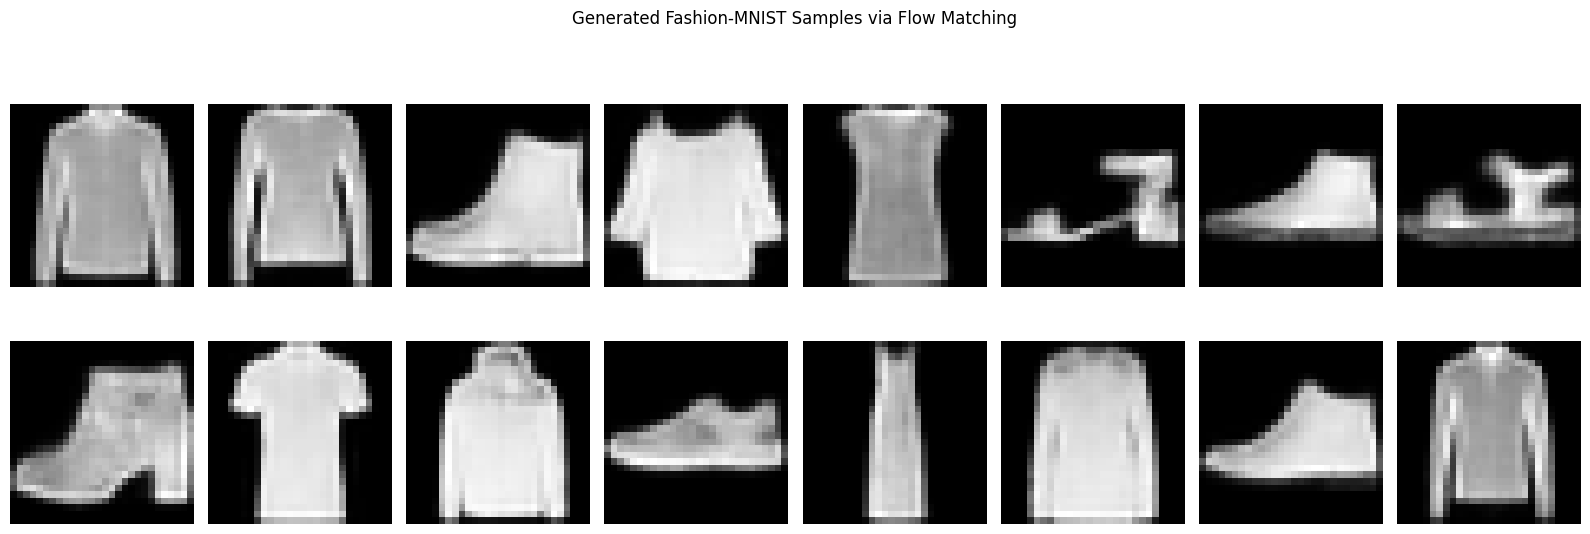

In [70]:
samples = generate_samples(20)

# Display Grid
fig, axes = plt.subplots(2, 8, figsize=(16, 6))
fig.suptitle("Generated Fashion-MNIST Samples via Flow Matching")
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 4. Sample Generation and Evaluation

The final step in our generative pipeline is the production of new synthetic images. Unlike the standard VAE, which samples directly from a Gaussian prior, our approach uses the Flow Matching model to "transport" noise into the meaningful regions of the latent space before decoding.

#### 4.1 The Generation Pipeline
To generate samples, we follow a three-step inference process:
1.  **Noise Sampling ($x_0$):** We start by sampling a vector $z_0$ from a standard 24-dimensional Gaussian distribution.
2.  **ODE Integration (The "Flow"):** We solve the learned Ordinary Differential Equation (ODE) using the `decode` method. This moves the noise vector along the learned vector field from $t=0$ to $t=1$, transforming it into a latent code $z_{gen}$ that follows the true distribution of FashionMNIST.
3.  **VAE Decoding:** The resulting latent code is passed through the frozen VAE decoder to produce the final $28 \times 28$ grayscale image.


#### 4.2 Comparative Results
When comparing the samples generated via Flow Matching to those produced by the standard VAE, the improvement is significant:
*   **Consistency:** Unlike the standard VAE, where random samples sometimes land in "low-density" regions of the latent space—resulting in unrealistic or blurry blobs, the Flow Matching samples almost exclusively produce recognizable clothing items.
*   **Fidelity:** The generated samples closely match the styles and shapes found in the original FashionMNIST dataset. By learning the "rich prior," the model avoids the regions between classes that do not correspond to real data.


---

## Final Conclusion

This project successfully demonstrated a two-stage generative framework for complex data.

In **Part I**, we established that while a Variational Autoencoder (VAE) provides a powerful method for representation learning and dimensionality reduction, the reliance on a simple Gaussian prior limits its generative potential. The trade-off between reconstruction and KL-regularization often leaves the latent space "imperfectly" populated.

In **Part II**, we addressed this limitation by implementing **Flow Matching** in the latent space. By learning a time-dependent vector field, we were able to transform simple noise into the complex, structured distribution of the data. This "prior learning" approach allows the model to respect the semantic boundaries of the dataset, resulting in high-quality, realistic, and diverse samples.

The combination of **Convolutional VAEs** for spatial feature extraction and **Optimal Transport Flow Matching** for latent distribution modeling represents a robust and scalable architecture for modern generative tasks, bridging the gap between simple probabilistic models and high-fidelity generative AI.